In [1]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [2]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [3]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [4]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [5]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [6]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [7]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [8]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [9]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [10]:
print(training_data_Y[0].shape)

(200,)


In [11]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [12]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [13]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [14]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [15]:
import torch.utils.data

In [16]:
# Dataset Hyper Parameters
num_epochs = 20
batch_size = 100

In [17]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [117]:
# Optimizer Hyper Parameters
learning_rate = 1e-3
reg_weight = 0.1
NUM_CLASSES = 4

# Debug Parameters
VERBOSE = False
PRINT_GRADS = False

from VanillaRNN import VanillaRNN

net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 32,
                recurrent_use_bias = True,
                recurrent_layer_num = 2,
                #recurrent_dropout = 0.25,
                final_hidden_layer_sizes = [],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = False

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)


for s in net.parameters():
    print('{}'.format(s.shape))
    

torch.Size([22])
torch.Size([22])
torch.Size([16, 22, 5])
torch.Size([16])
torch.Size([32, 16, 4])
torch.Size([32])
torch.Size([16, 32, 4])
torch.Size([16])
torch.Size([16, 16, 2])
torch.Size([16])
torch.Size([16])
torch.Size([16])
torch.Size([32, 16])
torch.Size([32, 32])
torch.Size([32])
torch.Size([32])
torch.Size([32, 32])
torch.Size([32, 32])
torch.Size([32])
torch.Size([32])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


torch.Size([1775, 4])


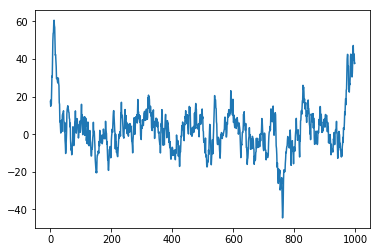

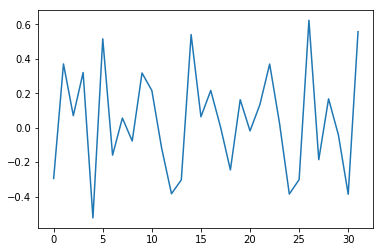

torch.Size([1775, 100])


In [106]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:    
    out, hidden = net.forward(tensor_x_train)
    
print(net.rnn_out.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/20], Iter [1/17] Loss: [----- 1.0788 = 1.0575 + 0.10 * 0.2123-----]
Epoch [1/20], Iter [2/17] Loss: [----- 1.0266 = 1.0262 + 0.10 * 0.0045-----]
Epoch [1/20], Iter [3/17] Loss: [----- 0.9467 = 0.8497 + 0.10 * 0.9696-----]
Epoch [1/20], Iter [4/17] Loss: [----- 1.0711 = 1.0596 + 0.10 * 0.1155-----]
Epoch [1/20], Iter [5/17] Loss: [----- 1.0099 = 0.9608 + 0.10 * 0.4903-----]
Epoch [1/20], Iter [6/17] Loss: [----- 0.9959 = 0.9956 + 0.10 * 0.0025-----]
Epoch [1/20], Iter [7/17] Loss: [----- 0.9452 = 0.9277 + 0.10 * 0.1748-----]
Epoch [1/20], Iter [8/17] Loss: [----- 1.0350 = 1.0294 + 0.10 * 0.0554-----]
Epoch [1/20], Iter [9/17] Loss: [----- 1.0229 = 1.0207 + 0.10 * 0.0224-----]
Epoch [1/20], Iter [10/17] Loss: [----- 1.2191 = 1.2188 + 0.10 * 0.0030-----]
Epoch [1/20], Iter [11/17] Loss: [----- 0.9311 = 0.9304 + 0.10 * 0.0076-----]
Epoch [1/20], Iter [12/17] Loss: [----- 1.1279 = 1.0332 + 0.10 * 0.9472-----]
Epoch [1/20], Iter [13/17] Loss: [----- 1.0463 = 1.0368 + 0.10 * 0.0952--

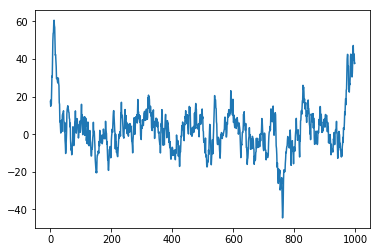

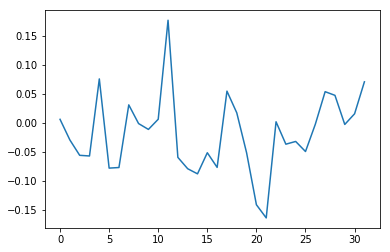

torch.Size([1775, 4])
Train Accuracy: 55 %


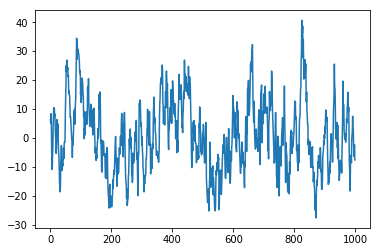

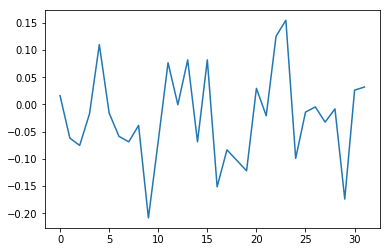

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [2/20], Iter [1/17] Loss: [----- 0.8703 = 0.8695 + 0.10 * 0.0080-----]
Epoch [2/20], Iter [2/17] Loss: [----- 1.0319 = 1.0315 + 0.10 * 0.0049-----]
Epoch [2/20], Iter [3/17] Loss: [----- 1.0283 = 0.9912 + 0.10 * 0.3712-----]
Epoch [2/20], Iter [4/17] Loss: [----- 0.9835 = 0.9319 + 0.10 * 0.5160-----]
Epoch [2/20], Iter [5/17] Loss: [----- 1.0097 = 0.9770 + 0.10 * 0.3266-----]
Epoch [2/20], Iter [6/17] Loss: [----- 1.0521 = 1.0388 + 0.10 * 0.1327-----]
Epoch [2/20], Iter [7/17] Loss: [----- 1.0130 = 0.9873 + 0.10 * 0.2572-----]
Epoch [2/20], Iter [8/17] Loss: [----- 0.9874 = 0.9796 + 0.10 * 0.0777-----]
Epoch [2/20], Iter [9/17] Loss: [----- 1.0508 = 1.0491 + 0.10 * 0.0169-----]
Epoch [2/20], Iter [10/17] Loss: [----- 1.0582 = 1.0340 + 0.10 * 0.2423-----]
Epoch [2/20], Iter [11/17] Loss: [----- 1.0508 = 1.0178 + 0.10 * 0.3294-----]
Epoch [2/20], Iter [12/17] Loss: [----- 0.9349 = 0.9283 + 0.10 * 0.0658-----]
Epo

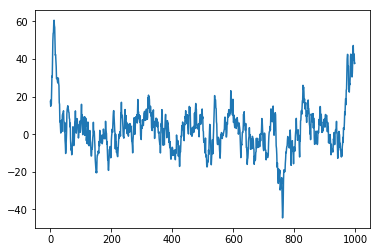

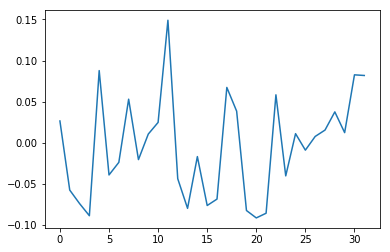

torch.Size([1775, 4])
Train Accuracy: 48 %


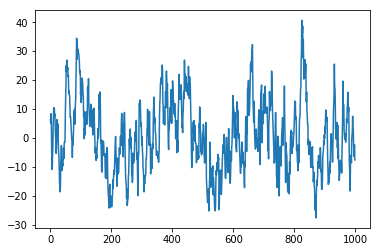

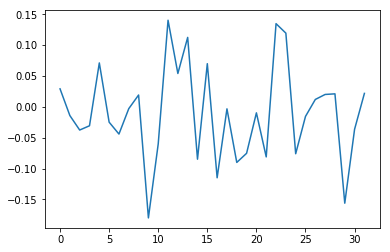

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [3/20], Iter [1/17] Loss: [----- 1.5829 = 0.8577 + 0.10 * 7.2513-----]
Epoch [3/20], Iter [2/17] Loss: [----- 0.9069 = 0.8961 + 0.10 * 0.1080-----]
Epoch [3/20], Iter [3/17] Loss: [----- 0.9908 = 0.9247 + 0.10 * 0.6607-----]
Epoch [3/20], Iter [4/17] Loss: [----- 0.9200 = 0.9107 + 0.10 * 0.0928-----]
Epoch [3/20], Iter [5/17] Loss: [----- 1.0705 = 0.9695 + 0.10 * 1.0107-----]
Epoch [3/20], Iter [6/17] Loss: [----- 0.9517 = 0.8963 + 0.10 * 0.5539-----]
Epoch [3/20], Iter [7/17] Loss: [----- 0.9693 = 0.8943 + 0.10 * 0.7505-----]
Epoch [3/20], Iter [8/17] Loss: [----- 1.0382 = 1.0366 + 0.10 * 0.0164-----]
Epoch [3/20], Iter [9/17] Loss: [----- 1.0559 = 1.0192 + 0.10 * 0.3662-----]
Epoch [3/20], Iter [10/17] Loss: [----- 0.9879 = 0.9696 + 0.10 * 0.1827-----]
Epoch [3/20], Iter [11/17] Loss: [----- 0.9518 = 0.9487 + 0.10 * 0.0306-----]
Epoch [3/20], Iter [12/17] Loss: [----- 1.0820 = 1.0067 + 0.10 * 0.7530-----]
Epo

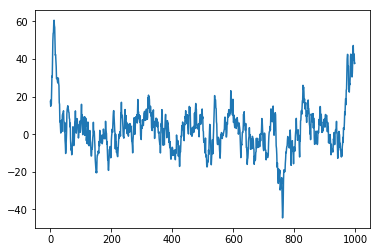

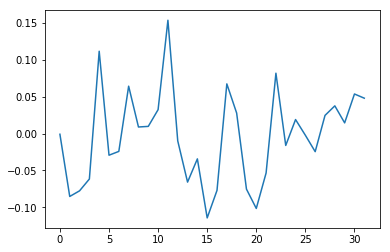

torch.Size([1775, 4])
Train Accuracy: 62 %


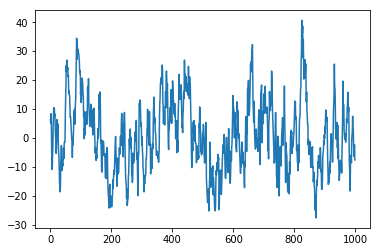

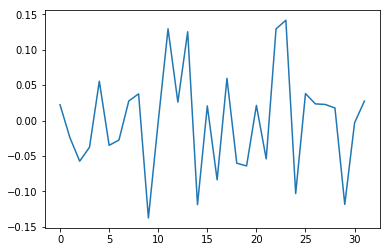

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [4/20], Iter [1/17] Loss: [----- 0.8858 = 0.8853 + 0.10 * 0.0050-----]
Epoch [4/20], Iter [2/17] Loss: [----- 0.8856 = 0.8801 + 0.10 * 0.0546-----]
Epoch [4/20], Iter [3/17] Loss: [----- 0.8268 = 0.8094 + 0.10 * 0.1737-----]
Epoch [4/20], Iter [4/17] Loss: [----- 0.9212 = 0.9211 + 0.10 * 0.0005-----]
Epoch [4/20], Iter [5/17] Loss: [----- 0.9075 = 0.9074 + 0.10 * 0.0009-----]
Epoch [4/20], Iter [6/17] Loss: [----- 1.0572 = 1.0352 + 0.10 * 0.2200-----]
Epoch [4/20], Iter [7/17] Loss: [----- 0.9185 = 0.9083 + 0.10 * 0.1022-----]
Epoch [4/20], Iter [8/17] Loss: [----- 0.9443 = 0.9387 + 0.10 * 0.0563-----]
Epoch [4/20], Iter [9/17] Loss: [----- 0.8531 = 0.8526 + 0.10 * 0.0055-----]
Epoch [4/20], Iter [10/17] Loss: [----- 0.9568 = 0.9563 + 0.10 * 0.0045-----]
Epoch [4/20], Iter [11/17] Loss: [----- 1.0947 = 1.0927 + 0.10 * 0.0205-----]
Epoch [4/20], Iter [12/17] Loss: [----- 0.9295 = 0.9227 + 0.10 * 0.0678-----]
Epo

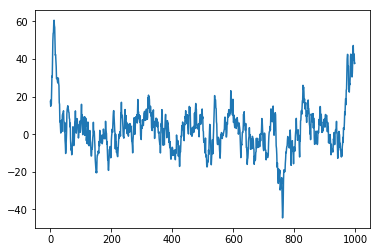

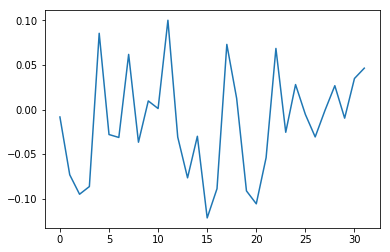

torch.Size([1775, 4])
Train Accuracy: 52 %


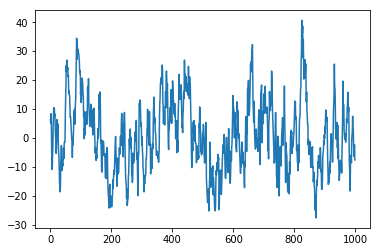

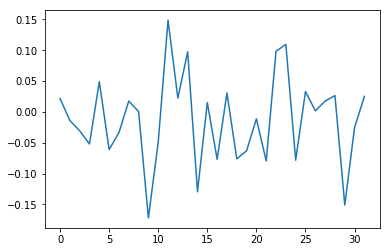

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 26 %
Epoch [5/20], Iter [1/17] Loss: [----- 0.7845 = 0.7842 + 0.10 * 0.0033-----]
Epoch [5/20], Iter [2/17] Loss: [----- 1.0158 = 0.9554 + 0.10 * 0.6045-----]
Epoch [5/20], Iter [3/17] Loss: [----- 0.9355 = 0.8538 + 0.10 * 0.8166-----]
Epoch [5/20], Iter [4/17] Loss: [----- 0.7991 = 0.7875 + 0.10 * 0.1159-----]
Epoch [5/20], Iter [5/17] Loss: [----- 1.2186 = 1.0579 + 0.10 * 1.6069-----]
Epoch [5/20], Iter [6/17] Loss: [----- 1.1494 = 0.8920 + 0.10 * 2.5741-----]
Epoch [5/20], Iter [7/17] Loss: [----- 0.9814 = 0.9378 + 0.10 * 0.4363-----]
Epoch [5/20], Iter [8/17] Loss: [----- 0.8655 = 0.8614 + 0.10 * 0.0409-----]
Epoch [5/20], Iter [9/17] Loss: [----- 1.0292 = 0.8253 + 0.10 * 2.0389-----]
Epoch [5/20], Iter [10/17] Loss: [----- 0.9820 = 0.9455 + 0.10 * 0.3651-----]
Epoch [5/20], Iter [11/17] Loss: [----- 0.8881 = 0.8663 + 0.10 * 0.2174-----]
Epoch [5/20], Iter [12/17] Loss: [----- 0.9886 = 0.9294 + 0.10 * 0.5920-----]
Epo

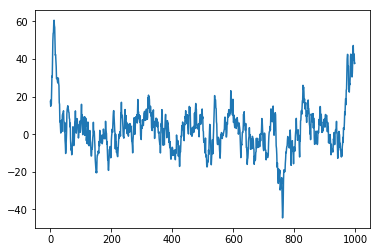

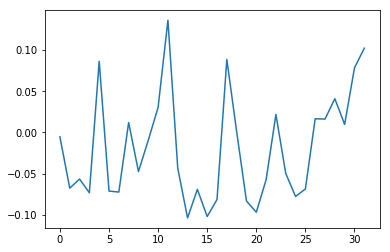

torch.Size([1775, 4])
Train Accuracy: 57 %


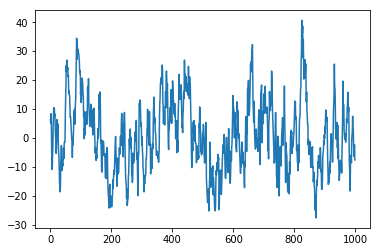

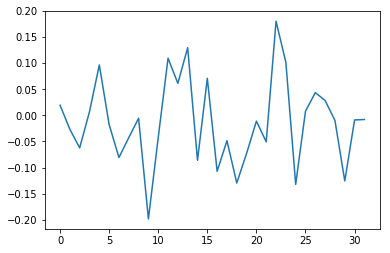

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [6/20], Iter [1/17] Loss: [----- 0.7495 = 0.7486 + 0.10 * 0.0092-----]
Epoch [6/20], Iter [2/17] Loss: [----- 0.9530 = 0.9067 + 0.10 * 0.4632-----]
Epoch [6/20], Iter [3/17] Loss: [----- 0.8846 = 0.8845 + 0.10 * 0.0015-----]
Epoch [6/20], Iter [4/17] Loss: [----- 0.8351 = 0.7992 + 0.10 * 0.3591-----]
Epoch [6/20], Iter [5/17] Loss: [----- 1.0158 = 0.9032 + 0.10 * 1.1263-----]
Epoch [6/20], Iter [6/17] Loss: [----- 0.9707 = 0.8992 + 0.10 * 0.7152-----]
Epoch [6/20], Iter [7/17] Loss: [----- 0.9172 = 0.8644 + 0.10 * 0.5274-----]
Epoch [6/20], Iter [8/17] Loss: [----- 0.8658 = 0.8640 + 0.10 * 0.0178-----]
Epoch [6/20], Iter [9/17] Loss: [----- 0.9202 = 0.9125 + 0.10 * 0.0765-----]
Epoch [6/20], Iter [10/17] Loss: [----- 0.8331 = 0.7781 + 0.10 * 0.5498-----]
Epoch [6/20], Iter [11/17] Loss: [----- 0.9282 = 0.9238 + 0.10 * 0.0440-----]
Epoch [6/20], Iter [12/17] Loss: [----- 1.0317 = 1.0213 + 0.10 * 0.1041-----]
Epo

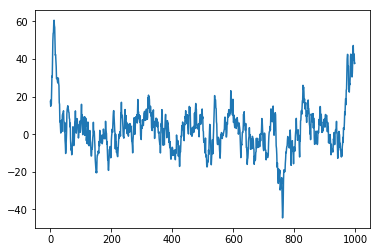

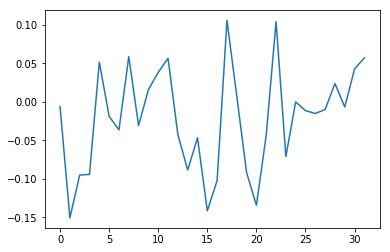

torch.Size([1775, 4])
Train Accuracy: 63 %


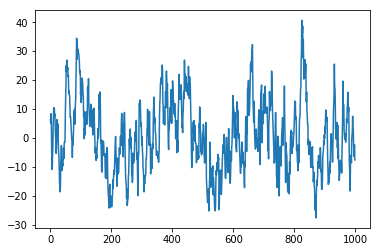

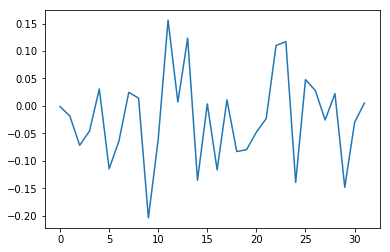

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [7/20], Iter [1/17] Loss: [----- 0.7941 = 0.7867 + 0.10 * 0.0735-----]
Epoch [7/20], Iter [2/17] Loss: [----- 1.0030 = 0.9915 + 0.10 * 0.1148-----]
Epoch [7/20], Iter [3/17] Loss: [----- 0.8868 = 0.8595 + 0.10 * 0.2730-----]
Epoch [7/20], Iter [4/17] Loss: [----- 0.7781 = 0.7748 + 0.10 * 0.0330-----]
Epoch [7/20], Iter [5/17] Loss: [----- 1.0021 = 0.9913 + 0.10 * 0.1075-----]
Epoch [7/20], Iter [6/17] Loss: [----- 0.8111 = 0.7997 + 0.10 * 0.1141-----]
Epoch [7/20], Iter [7/17] Loss: [----- 0.8331 = 0.8298 + 0.10 * 0.0334-----]
Epoch [7/20], Iter [8/17] Loss: [----- 0.8802 = 0.8759 + 0.10 * 0.0432-----]
Epoch [7/20], Iter [9/17] Loss: [----- 0.9254 = 0.9097 + 0.10 * 0.1575-----]
Epoch [7/20], Iter [10/17] Loss: [----- 0.7032 = 0.6995 + 0.10 * 0.0373-----]
Epoch [7/20], Iter [11/17] Loss: [----- 0.9045 = 0.8681 + 0.10 * 0.3643-----]
Epoch [7/20], Iter [12/17] Loss: [----- 0.8802 = 0.8534 + 0.10 * 0.2684-----]
Epo

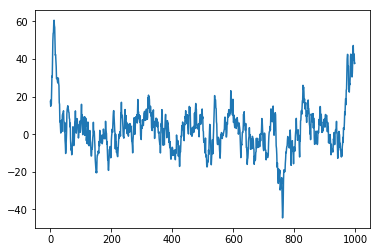

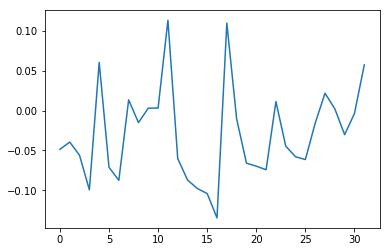

torch.Size([1775, 4])
Train Accuracy: 57 %


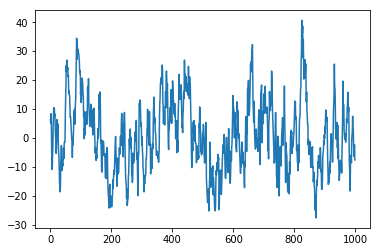

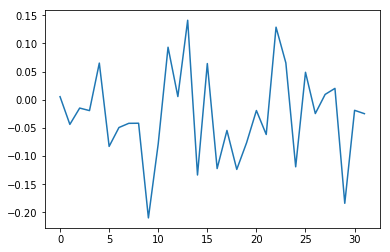

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [8/20], Iter [1/17] Loss: [----- 0.8255 = 0.8254 + 0.10 * 0.0016-----]
Epoch [8/20], Iter [2/17] Loss: [----- 0.8263 = 0.8261 + 0.10 * 0.0023-----]
Epoch [8/20], Iter [3/17] Loss: [----- 0.7269 = 0.7149 + 0.10 * 0.1202-----]
Epoch [8/20], Iter [4/17] Loss: [----- 0.7565 = 0.7552 + 0.10 * 0.0136-----]
Epoch [8/20], Iter [5/17] Loss: [----- 0.7586 = 0.7577 + 0.10 * 0.0090-----]
Epoch [8/20], Iter [6/17] Loss: [----- 0.8595 = 0.8584 + 0.10 * 0.0109-----]
Epoch [8/20], Iter [7/17] Loss: [----- 0.7823 = 0.7768 + 0.10 * 0.0551-----]
Epoch [8/20], Iter [8/17] Loss: [----- 0.8995 = 0.8969 + 0.10 * 0.0258-----]
Epoch [8/20], Iter [9/17] Loss: [----- 0.8743 = 0.8007 + 0.10 * 0.7363-----]
Epoch [8/20], Iter [10/17] Loss: [----- 0.8042 = 0.7777 + 0.10 * 0.2650-----]
Epoch [8/20], Iter [11/17] Loss: [----- 0.9029 = 0.9000 + 0.10 * 0.0298-----]
Epoch [8/20], Iter [12/17] Loss: [----- 1.0416 = 1.0221 + 0.10 * 0.1957-----]
Epo

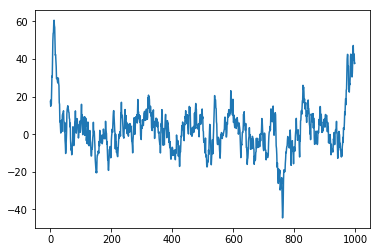

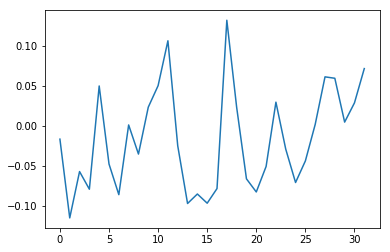

torch.Size([1775, 4])
Train Accuracy: 52 %


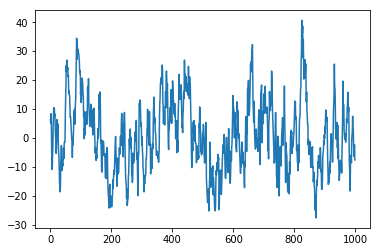

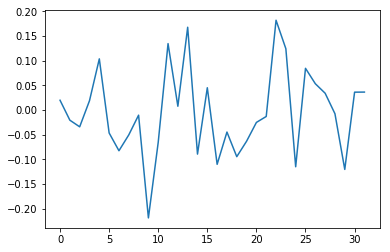

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [9/20], Iter [1/17] Loss: [----- 0.7534 = 0.7495 + 0.10 * 0.0394-----]
Epoch [9/20], Iter [2/17] Loss: [----- 0.8533 = 0.8187 + 0.10 * 0.3463-----]
Epoch [9/20], Iter [3/17] Loss: [----- 0.7406 = 0.7298 + 0.10 * 0.1083-----]
Epoch [9/20], Iter [4/17] Loss: [----- 0.8693 = 0.8688 + 0.10 * 0.0055-----]
Epoch [9/20], Iter [5/17] Loss: [----- 0.8588 = 0.8587 + 0.10 * 0.0007-----]


In [ ]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
            
        labels = Variable(labels)

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)

        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        loss1.backward(retain_graph=True)
        
        nl = net.loss_regularizer()
        
        loss = loss1 + reg_weight*nl

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
        
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f = %.4f + %.2f * %.4f-----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size,
                 loss.data[0], loss1.data[0], reg_weight, nl.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    bad_grads = []
    for n,p in net.named_parameters():
        grad_max = torch.max(p.grad)
        abs_grad_mean = torch.mean(torch.abs(p.grad))
        if (PRINT_GRADS):
            print('===========\ngradient:{}'.format(n))
            print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))
            
        stats = [n, grad_max, abs_grad_mean]
        
        if (abs_grad_mean < 1e-5):
            stats.append('SMALL')
            bad_grads.append(stats)
        elif (1 < abs_grad_mean):
            stats.append('BIG')
            bad_grads.append(stats)
            
    for n, grad_max, abs_grad_mean, descr in bad_grads:
        print('===========\n {} gradient:{}'.format(descr, n))
        print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))  
        
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * int(correct) / float(total)))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100 * correct / total))

In [116]:
l = list(net.layer1.modules())
print(l[1].running_mean)
print(l[1].running_var)


 0.2320
 0.2928
 0.2867
 0.2776
 0.2940
 0.3093
 0.3722
 0.3570
 0.3030
 0.2924
 0.2994
 0.3299
 0.3383
 0.3730
 0.3764
 0.3794
 0.3260
 0.3303
 0.3158
 0.3569
 0.3735
 0.3406
[torch.FloatTensor of size (22,)]


 128.5609
 106.0961
 120.2741
 132.9721
 126.8234
 119.8886
  77.5029
 102.5849
 115.4050
 129.3320
 121.3680
 119.7015
 103.3743
 108.4402
 114.3926
 124.2197
 122.0159
 124.4923
 118.3511
 128.1105
 126.3401
 130.9359
[torch.FloatTensor of size (22,)]

